In [36]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=2)
tokenizer =  AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

2024-04-29 13:13:04.025967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 13:13:04.026070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 13:13:04.177854: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [37]:
import pandas as pd
df = pd.read_csv("/kaggle/input/trainfnd/Train_cleaned3.csv")
df.shape

(75004, 5)

In [38]:
df = df.fillna('')
df.head(5)

,content,label,author,source,title
0,đến 18h chiều 104 thêm 2 ca mắc covid19 bn 2...,1,đinh trọng tuấn,instagram,unknown
1,thế giới tuần qua nợ công mỹ tăng kinh hoàng v...,1,le phuong,telegram,
2,sự_cố đứt cáp aag không ảnh_hưởng tới chất_lượ...,1,vitenam true,unknown,unknown
3,triệu chứng nhiễm corona qua từng ngày ngày 1 ...,1,ẩn danh,instagram,
4,url bị phong tỏa từ ngày 283 phong tỏa 14 ngày...,1,chưa biết 1,telegram,


In [8]:
df['news_content'] = df['title'] + ' ' + df['content'] + ' ' + df['author'] + ' ' + df['source']


In [39]:
df['news_content'] = df['content']

In [40]:
sentences = df.news_content.values

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [41]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [42]:
# from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 256
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
attention_masks = []
# Tạo mask chứa các giá trị 1 cho mỗi koten và 0 cho các giá trị đệm
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [43]:
# import torch
# from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.2)
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [44]:
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 40
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [45]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [46]:
from transformers import AdamW

# Khai báo tối ưu hóa AdamW với các siêu tham số
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, correct_bias=False)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [47]:
# Hàm để tính độ chính xác giữa kết quả dự đoán và nhãn thực
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [48]:
dropout_rate = 0.2
model.config.hidden_dropout_prob = dropout_rate
model.config.attention_probs_dropout_prob = dropout_rate

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

# Khởi tạo danh sách lưu giá trị loss và thời gian mỗi epoch
train_loss_set = []
train_accuracy_set = []
epoch_times = []

# Xác định thiết bị dựa trên việc có GPU hay không
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {'GPU' if torch.cuda.is_available() else 'CPU'}")

# Khởi tạo hàm mất mát
criterion = nn.CrossEntropyLoss()

# Số lượng epoch huấn luyện
epochs = 1

for epoch in tqdm(range(epochs), desc="Epoch"):
    start_time = time.time()

    model.train()
    total_train_loss = 0
    total_train_steps = 0
    total_train_accuracy = 0

    # Chuyển model vào thiết bị thích hợp
    model.to(device)

    # Huấn luyện model
    for step, batch in enumerate(train_dataloader):
        # Chuyển batch dữ liệu vào cùng thiết bị với model
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()
        
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        # Tính toán hàm mất mát
        loss = criterion(outputs.logits, b_labels)
        
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_steps += 1
        train_loss_set.append(loss.item())

        # Calculate accuracy for each batch
        logits = outputs.logits.detach()
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == b_labels).float().mean()
        total_train_accuracy += accuracy.item()

    avg_train_loss = total_train_loss / total_train_steps
    avg_train_accuracy = total_train_accuracy / total_train_steps
    train_accuracy_set.append(avg_train_accuracy)
    print(f"Epoch {epoch + 1} Train loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")

    # Đánh giá model
    model.eval()
    eval_accuracy = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        # Chuyển batch dữ liệu vào cùng thiết bị với model
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits.detach().cpu()
            predictions = torch.argmax(logits, dim=-1)
            label_ids = b_labels.to('cpu').numpy()

        # Calculate accuracy for each validation batch
        tmp_eval_accuracy = (predictions.cpu().numpy() == label_ids).mean()
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    if nb_eval_steps > 0:
        avg_eval_accuracy = eval_accuracy / nb_eval_steps
        print(f"Epoch {epoch + 1} Validation Accuracy: {avg_eval_accuracy:.4f}")
    else:
        print(f"Epoch {epoch + 1}: No validation steps completed.")

    end_time = time.time()
    epoch_time = end_time - start_time
    epoch_times.append(epoch_time)
    print(f"Epoch {epoch + 1} Time: {epoch_time:.2f} s")

# Tính thời gian trung bình mỗi epoch
avg_epoch_time = sum(epoch_times) / len(epoch_times)
print(f"Average Training Time per Epoch: {avg_epoch_time:.2f} seconds")


Using GPU


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 Train loss: 0.0027, Train Accuracy: 0.9994


Epoch: 100%|██████████| 1/1 [25:11<00:00, 1511.87s/it]

Epoch 1 Validation Accuracy: 0.9993
Epoch 1 Time: 1511.87 s
Average Training Time per Epoch: 1511.87 seconds


In [20]:
# # Lưu toàn bộ mô hình
# torch.save(model, '/kaggle/working/model_complete.pth')

# # Hoặc lưu chỉ state_dict của mô hình
# torch.save(model.state_dict(), '/kaggle/working/model_state_dict.pth')

# # Lưu state_dict của optimizer, nếu bạn muốn tiếp tục huấn luyện sau này
# torch.save(optimizer.state_dict(), '/kaggle/working/optimizer_state_dict.pth')


In [53]:
from sklearn.metrics import precision_score, f1_score

# Tính Precision và F1-Score
y_true = []  # Nhãn thực tế
y_pred = []  # Dự đoán từ mô hình
for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits.detach().cpu()
        predictions = torch.argmax(logits, dim=-1)
        label_ids = b_labels.to('cpu').numpy()

    y_true.extend(label_ids)
    y_pred.extend(predictions.cpu().numpy())

precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

# Thời gian huấn luyện trung bình mỗi epoch
avg_epoch_time = sum(epoch_times) / len(epoch_times)
print(f"Average Training Time per Epoch: {avg_epoch_time:.2f} seconds")


Precision: 0.9992
F1-Score: 0.9990
Average Training Time per Epoch: 1511.87 seconds


In [ ]:
df = pd.read_csv("/kaggle/input/testfnd/Test.csv")
df = df.fillna('')
df.head(5)

In [45]:
df['news_content'] = df['title'] + ' ' + df['content'] + ' ' + df['author'] + ' ' + df['source']

In [55]:
df['news_content'] = df['content']

In [56]:
df

,content,label,author,source,title,news_content
0,đến 18h chiều 104 thêm 2 ca mắc covid19 bn 2...,1,đinh trọng tuấn,instagram,unknown,đến 18h chiều 104 thêm 2 ca mắc covid19 bn 2...
1,thế giới tuần qua nợ công mỹ tăng kinh hoàng v...,1,le phuong,telegram,,thế giới tuần qua nợ công mỹ tăng kinh hoàng v...
2,sự_cố đứt cáp aag không ảnh_hưởng tới chất_lượ...,1,vitenam true,unknown,unknown,sự_cố đứt cáp aag không ảnh_hưởng tới chất_lượ...
3,triệu chứng nhiễm corona qua từng ngày ngày 1 ...,1,ẩn danh,instagram,,triệu chứng nhiễm corona qua từng ngày ngày 1 ...
4,url bị phong tỏa từ ngày 283 phong tỏa 14 ngày...,1,chưa biết 1,telegram,,url bị phong tỏa từ ngày 283 phong tỏa 14 ngày...
...,...,...,...,...,...,...
74999,trong hâm mộ bridgerton nóng chờ đợi phim chiế...,0,thành đạt,zingnews,Tiền truyện Bridgerton tiết lộ bí mật Nữ hoàng...,trong hâm mộ bridgerton nóng chờ đợi phim chiế...
75000,man united hy vọng chuyến du đấu mùa giải tuy ...,0,huy hoàng,laodong,Man United chân thương vụ De Jong,man united hy vọng chuyến du đấu mùa giải tuy ...
75001,ngày 97 cơ quan csđt công an tỉnh cà mau đơn v...,0,trường thịnh,thanhnien.vn,Cà Mau: Phát hiện thi thể nam công nhân 19 ven...,ngày 97 cơ quan csđt công an tỉnh cà mau đơn v...
75002,ngày 97 lãnh đạo ubnd xã buôn triết hlắk đắk l...,0,đặng linh,thanhnien.vn,Phát hiện đàn tử vong xe Thái Bình Đắk Lắk,ngày 97 lãnh đạo ubnd xã buôn triết hlắk đắk l...


In [57]:
# Danh sách câu và nhãn
sentences = df.news_content.values

# Thêm token đặc biệt vào đầu vào cuối câu để BERT hoạt động đúng
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 256
# Sử dụng bộ tách từ của BERT để chuyển token thành số định danh trong tập từ điển của BERT
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Đệm thêm vào đầu vào
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Tạo attention masks
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 40  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [58]:
# Dự đoán trên tập test

# Đưa mô hình vào chế độ đánh giá
model.eval()

# Các biến theo dõi
predictions, true_labels = [], []

# Dự đoán
for batch in prediction_dataloader:
  # Đưa vào GPU
  batch = tuple(t.to(device) for t in batch)
  # Lấy dữ liệu đầu vào từ dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Yêu cầu mô hình không tính gradient, tiết kiệm bộ nhớ và tăng tốc
  with torch.no_grad():
    # Truyền dữ liệu, tính toán giá trị dự đoán
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs.logits  # Truy cập vào logits

  # Đưa giá trị dự đoán và nhãn thật về CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Lưu giá trị dự đoán và nhãn thật
  predictions.append(logits)
  true_labels.append(label_ids)


In [59]:
# Gọi và sử dụng thư viện matthews_corrcoef để đánh giá 
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels))::))
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [60]:
# Duỗi giá trị dự đoán và nhãn thật để sử dụng độ đo Matthew trên toàn bộ dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [61]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.9993822813741046

In [62]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Chuyển đổi logits thành nhãn dự đoán
predicted_labels = []
for batch_prediction in predictions:
    batch_predicted_labels = np.argmax(batch_prediction, axis=1)
    predicted_labels.extend(batch_predicted_labels)

# Chuyển đổi danh sách nhãn thật thành mảng 1D
true_labels_flat = np.concatenate(true_labels)

# Tính toán các độ đo
accuracy = accuracy_score(true_labels_flat, predicted_labels)
f1 = f1_score(true_labels_flat, predicted_labels)
recall = recall_score(true_labels_flat, predicted_labels)
precision = precision_score(true_labels_flat, predicted_labels)

# In ra các độ đo
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)


Accuracy: 0.9997200149325369
F1 Score: 0.9995967044996255
Recall: 0.9995775080657551
Precision: 0.9996159016708277


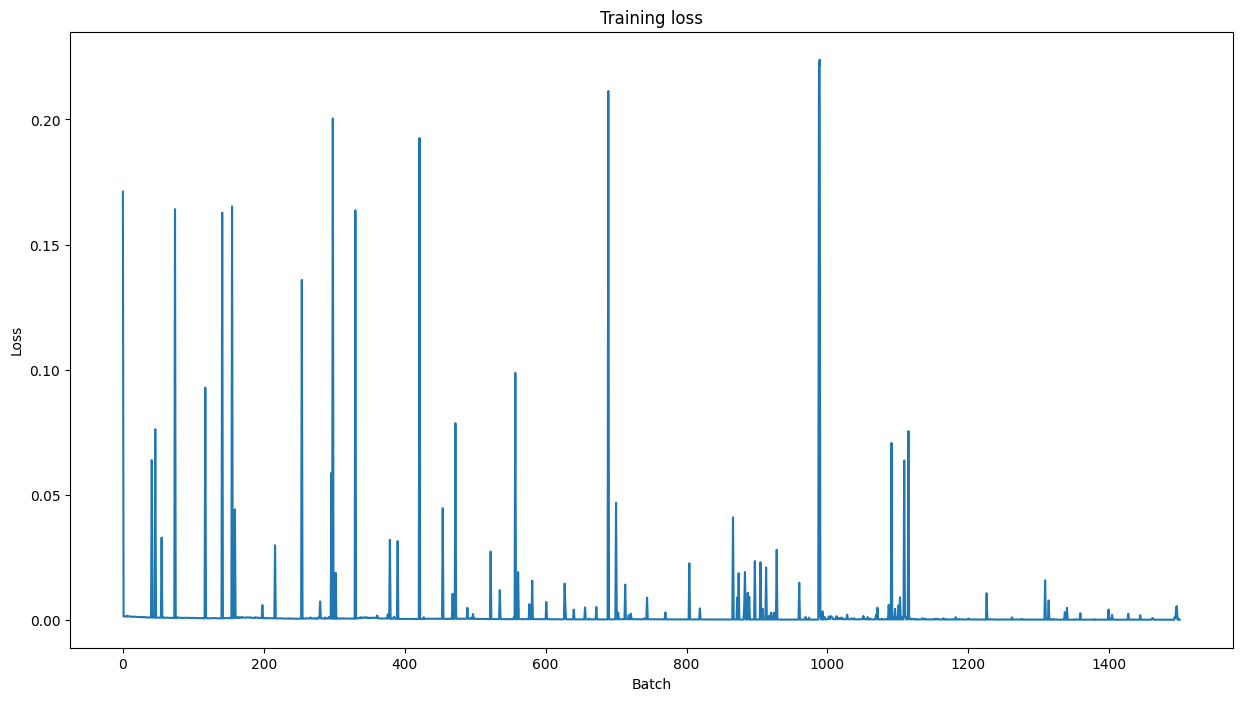

In [63]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()